In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState

In [7]:
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

class OverallState(MessagesState):
    question: str
    llm_calls: int
    answer: str

In [8]:
def call_model(state: OverallState, config: RunnableConfig):
    language = config["configurable"].get("language", "English")
    system_message_content = "Respond in {}".format(language)
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message, HumanMessage(content=state["question"])]
    response = model.invoke(messages)
    return {"answer": response}

In [9]:
workflow = StateGraph(OverallState)

workflow.add_edge(START, "agent")
workflow.add_node("agent", call_model)
workflow.add_edge("agent", END)

graph = workflow.compile()

In [11]:
config = {"configurable": {"language": "tamil"}}
graph.invoke({"question": "What's the highest mountain in the world?"}, config=config)

{'messages': [],
 'question': "What's the highest mountain in the world?",
 'answer': AIMessage(content='உலகில் உள்ள உயரமான மலை எவர் என்றால், எவரேஸ்ட் மலை (Mount Everest) ஆகும். இதன் உயரம் 8,848 மீட்டர் (29,029 அடிகள்) ஆகும்.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 22, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'finish_reason': 'stop', 'logprobs': None}, id='run-0925302e-c340-4e90-b123-774a0305b20a-0', usage_metadata={'input_tokens': 22, 'output_tokens': 49, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [12]:
config = {"configurable": {"language": "German"}}
graph.invoke({"question": "What's the highest mountain in the world?"}, config=config)

{'messages': [],
 'question': "What's the highest mountain in the world?",
 'answer': AIMessage(content='Der höchste Berg der Welt ist der Mount Everest, der sich an der Grenze zwischen Nepal und Tibet befindet. Er hat eine Höhe von 8.848 Metern über dem Meeresspiegel.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 22, 'total_tokens': 60, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'finish_reason': 'stop', 'logprobs': None}, id='run-c5e1413e-b31b-41e4-943d-7224a960469f-0', usage_metadata={'input_tokens': 22, 'output_tokens': 38, 'total_tokens': 60, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

checkpointer = MemorySaver()

graph_builder = StateGraph(State)


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."


@tool
def broken_api(location: str):
    """Call to get the current weather."""
    return f"Currently no weather data available for {location}. Please try again later"


tools = [get_weather, broken_api]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [15]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["tools"],
)

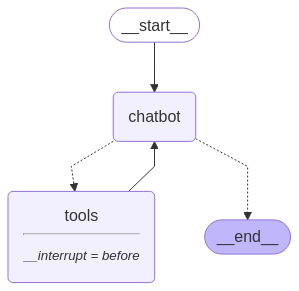

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Hello, I am John")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='415858f0-91e3-4ec0-8798-dce9f4462419'),
  AIMessage(content='Hello John! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'finish_reason': 'stop', 'logprobs': None}, id='run-1e08412b-774b-4cda-a5c9-f4b196bd82be-0', usage_metadata={'input_tokens': 70, 'output_tokens': 12, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [18]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Sorry, did I already introduce myself?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='415858f0-91e3-4ec0-8798-dce9f4462419'),
  AIMessage(content='Hello John! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'finish_reason': 'stop', 'logprobs': None}, id='run-1e08412b-774b-4cda-a5c9-f4b196bd82be-0', usage_metadata={'input_tokens': 70, 'output_tokens': 12, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='Sorry, did I already introduce myself?', additional_kwargs={}, resp

In [19]:
snapshot = graph.get_state(config)
snapshot.next

()

In [20]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="How is the weather in Munich?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='2ada974d-f5c8-44cb-a6a1-eeab261efa7a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KPyxuugvusA74aPopJKyyRyK', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fb53267b-fbfa-4918-8f76-8578f9ec2564-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_KPyxuugvusA74aPopJKyyRyK', 'type': 'tool_call'}], usage_metadata={

In [21]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [22]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='2ada974d-f5c8-44cb-a6a1-eeab261efa7a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KPyxuugvusA74aPopJKyyRyK', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fb53267b-fbfa-4918-8f76-8578f9ec2564-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_KPyxuugvusA74aPopJKyyRyK', 'type': 'tool_call'}], usage_metadata={